# Table of contents  

<a href=#I>I. Data folder</a>     
<a href=#II>II. Dataset preparation </a>   
<a href=#III>III. Exploratory data analysis </a>   
<a href=#IV>IV. Data tranformation for modelling</a>    
<a href=#V>V. Feature selection </a>   
<a href=#VI>VI. Classification model for phenotype scoring  </a>   
    
<a href=#RawData2R> Loading raw data to R</a>   
<a href=#Data2R> Loading data with selected variables to R</a>   

<a name="Top" /a>

# I. Data folder

Data are saved in three relevant files: \*SegmentedNuclei.csv, \*ShrunkenNuclei.csv and \*Speckles.csv. For the purpose of the project (recognizing discrimanant variables for follow-up hypothesis-driven experimentation), only the first two will be considered.   

Spend some time getting to know your data. Run some exploratory plotting.     
 <a name='I' /a> 

In [42]:
!ls -lh ../Data/

total 131640
-rw-r--r--  1 andi  staff    26K Feb 11 23:54 Anne_20160211Experiment.csv
-rw-r--r--  1 andi  staff   236K Feb 11 23:54 Anne_20160211Image.csv
-rw-r--r--  1 andi  staff   9.6M Feb 11 23:54 Anne_20160211SegmentedNuclei.csv
-rw-r--r--  1 andi  staff    10M Feb 11 23:55 Anne_20160211ShrunkenNuclei.csv
-rw-r--r--  1 andi  staff    44M Feb 11 23:55 Anne_20160211Speckles.csv


Below, we will determine how many columns/variables we have in the dataset.

In [43]:
!head -n2 ../Data/Anne_20160211SegmentedNuclei.csv | awk 'BEGIN{FS=","}{print NF}'

155
155


In [44]:
!tail -n +2 ../Data/Anne_20160211SegmentedNuclei.csv | wc -l 

    3549


In [45]:
!head -n2 ../Data/Anne_20160211ShrunkenNuclei.csv | awk 'BEGIN{FS=","}{print NF}'

177
177


The file above has additional variables quantified.

In [46]:
!tail -n +2 ../Data/Anne_20160211ShrunkenNuclei.csv | wc -l 

    3549


In [47]:
!head -n2 ../Data/Anne_20160211Speckles.csv | awk 'BEGIN{FS=","}{print NF}'

82
82


In [48]:
!tail -n +2 ../Data/Anne_20160211Speckles.csv  | wc -l 

   32211


# II. Dataset preparation    
## Final dataset assembly 
In general, data are spread across the three files listed above, albeit there is most likely quite some redundancy. We can, however, build one dataset and then drop some of the feaures. Speckle descriptors will be kept seperate. At the moment there is no point in putting them in.   
    
Variables to remove:    
- object locators (_X, _Y)    
- most of the metadata (leave: 'Metadata_ExperimentID', 'Metadata_ImageID', 'Metadata_Treatment')
- one of the two: 'ObjectNumber' or 'Number_Object_Number'     
Neither Metadata_ImageID nor *objectNumber should be of any value.

<a name='II'/a>   
<a href=#Top>Top</a>  

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
pd.set_option('display.mpl_style','default')

from matplotlib.backends.backend_pdf import PdfPages

import sklearn

%load_ext rpy2.ipython
%matplotlib inline

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [50]:
%%R
library(ggplot2)
library(caret)
library(corrplot)
library(psych)
library(ggbiplot)


Below is the list of variables in the file describing detected nuclei.

In [51]:
!head -n2 ../Data/Anne_20160211SegmentedNuclei.csv

In [52]:
!head -n2 ../Data/Anne_20160211ShrunkenNuclei.csv

In [53]:
!head -n2 ../Data/Anne_20160211Speckles.csv

Loading data...

In [54]:
df_n = pd.read_csv('../Data/Anne_20160211SegmentedNuclei.csv')
df_sn = pd.read_csv('../Data/Anne_20160211ShrunkenNuclei.csv')
df_sp = pd.read_csv('../Data/Anne_20160211Speckles.csv')

Dimensions of individual datasets (nuclei and shrunken nuclei are organized by nucleus, speckles - by speckle object, there is a corresponding nucleus parent in among other variables):

In [55]:
df_n.shape, df_sn.shape, df_sp.shape

((3549, 155), (3549, 177), (32211, 82))

Nuclei (df_n) and shrunken nuclei (df_sn) can be merged and should have dimensions (merging on ImageNumber and ObjectNumber): 

In [56]:
155+177-2

330

### Overview of the dataset

The first two columns contain object identifiers (image and object ID). The object ID appears again at the end of the data frame ('ObjectNumber', 'Number_Object_Number').

In [57]:
df_n.ImageNumber.head(), \
df_sn.ImageNumber.head(), \
df_sp.ImageNumber.head(), \

(0    1
 1    1
 2    1
 3    1
 4    1
 Name: ImageNumber, dtype: int64, 0    1
 1    1
 2    1
 3    1
 4    1
 Name: ImageNumber, dtype: int64, 0    1
 1    1
 2    1
 3    1
 4    1
 Name: ImageNumber, dtype: int64)

In [58]:
df_n.ObjectNumber.head(), \
df_sn.ObjectNumber.head(), \
df_n.Metadata_ImageID.head(), \
#df_nuclei.Metadata_FileLocation.head()[0], \
#df_sh_nuclei.Metadata_FileLocation.head()[0]

(0    1
 1    2
 2    3
 3    4
 4    5
 Name: ObjectNumber, dtype: int64, 0    1
 1    2
 2    3
 3    4
 4    5
 Name: ObjectNumber, dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 Name: Metadata_ImageID, dtype: int64)

Best idea is to merge data on file location or ID AND object ID. It is obvious if you look below at the subset of the two files.

In [59]:
df_n.iloc[0:5,0:4]

,ImageNumber,ObjectNumber,Metadata_ExperimentID,Metadata_FileLocation
0,1,1,Exp1,file:/Volumes/Seagate_RED/A_Heald_Lab/A_My_pap...
1,1,2,Exp1,file:/Volumes/Seagate_RED/A_Heald_Lab/A_My_pap...
2,1,3,Exp1,file:/Volumes/Seagate_RED/A_Heald_Lab/A_My_pap...
3,1,4,Exp1,file:/Volumes/Seagate_RED/A_Heald_Lab/A_My_pap...
4,1,5,Exp1,file:/Volumes/Seagate_RED/A_Heald_Lab/A_My_pap...


In [60]:
df_sn.iloc[0:5, 0:4]

,ImageNumber,ObjectNumber,Metadata_ExperimentID,Metadata_FileLocation
0,1,1,Exp1,file:/Volumes/Seagate_RED/A_Heald_Lab/A_My_pap...
1,1,2,Exp1,file:/Volumes/Seagate_RED/A_Heald_Lab/A_My_pap...
2,1,3,Exp1,file:/Volumes/Seagate_RED/A_Heald_Lab/A_My_pap...
3,1,4,Exp1,file:/Volumes/Seagate_RED/A_Heald_Lab/A_My_pap...
4,1,5,Exp1,file:/Volumes/Seagate_RED/A_Heald_Lab/A_My_pap...


Below is the merging step. It makes more sense to execute it after the unnecessary variables are removed. Below is a trial run.

In [61]:
m_nuc = pd.merge(df_n, df_sn, how = 'left', on = ['ImageNumber', 'ObjectNumber'])

In [62]:
155+177-2

330

In [63]:
m_nuc.shape

(3549, 330)

In [64]:
m_nuc.iloc[0:5,0:4]

,ImageNumber,ObjectNumber,Metadata_ExperimentID_x,Metadata_FileLocation_x
0,1,1,Exp1,file:/Volumes/Seagate_RED/A_Heald_Lab/A_My_pap...
1,1,2,Exp1,file:/Volumes/Seagate_RED/A_Heald_Lab/A_My_pap...
2,1,3,Exp1,file:/Volumes/Seagate_RED/A_Heald_Lab/A_My_pap...
3,1,4,Exp1,file:/Volumes/Seagate_RED/A_Heald_Lab/A_My_pap...
4,1,5,Exp1,file:/Volumes/Seagate_RED/A_Heald_Lab/A_My_pap...


It is advisable to cleanup the variable list first, otherwise one need to take care of the variables twice.

In [65]:
m_nuc.columns

Index([u'ImageNumber', u'ObjectNumber', u'Metadata_ExperimentID_x',
       u'Metadata_FileLocation_x', u'Metadata_Frame_x', u'Metadata_ImageID_x',
       u'Metadata_Series_x', u'Metadata_Stain_x', u'Metadata_Treatment_x',
       u'AreaShape_Area',
       ...
       u'Texture_SumEntropy_RawInput_5_0_y',
       u'Texture_SumEntropy_RawInput_5_90_y',
       u'Texture_SumVariance_RawInput_10_0_y',
       u'Texture_SumVariance_RawInput_10_90_y',
       u'Texture_SumVariance_RawInput_5_0_y',
       u'Texture_SumVariance_RawInput_5_90_y',
       u'Texture_Variance_RawInput_10_0_y',
       u'Texture_Variance_RawInput_10_90_y',
       u'Texture_Variance_RawInput_5_0_y',
       u'Texture_Variance_RawInput_5_90_y'],
      dtype='object', length=330)

The dimensions are as planned.

In [66]:
df_sp.iloc[0:30, 0:5]

,ImageNumber,ObjectNumber,Metadata_ExperimentID,Metadata_FileLocation,Metadata_Frame
0,1,1,Exp1,file:/Volumes/Seagate_RED/A_Heald_Lab/A_My_pap...,0
1,1,2,Exp1,file:/Volumes/Seagate_RED/A_Heald_Lab/A_My_pap...,0
2,1,3,Exp1,file:/Volumes/Seagate_RED/A_Heald_Lab/A_My_pap...,0
3,1,4,Exp1,file:/Volumes/Seagate_RED/A_Heald_Lab/A_My_pap...,0
4,1,5,Exp1,file:/Volumes/Seagate_RED/A_Heald_Lab/A_My_pap...,0
5,1,6,Exp1,file:/Volumes/Seagate_RED/A_Heald_Lab/A_My_pap...,0
6,1,7,Exp1,file:/Volumes/Seagate_RED/A_Heald_Lab/A_My_pap...,0
7,1,8,Exp1,file:/Volumes/Seagate_RED/A_Heald_Lab/A_My_pap...,0
8,1,9,Exp1,file:/Volumes/Seagate_RED/A_Heald_Lab/A_My_pap...,0
9,1,10,Exp1,file:/Volumes/Seagate_RED/A_Heald_Lab/A_My_pap...,0


Below we define types of variables.

Accessory functions:   
**Object locators** are defined by a suffix \_X and \_Y. 
Have in mind that the way the speckles are spatially distributed may have a significance too. Here, we'll ignore this aspect.    
**Metadata** contain experimental details. They are, in fact, categorical explanatory (or confounding) variables. 

In [67]:
def findLocatorsInDF(data_frame):
    ''' A number of variables have a 2D location specifiers (suffix _X and _Y). Uses REGEX to select the columns.
        Returns list of locator variables.
    '''
    
    pattern = re.compile(r'.*_X.*|.*_Y.*')
    list_of_locators = []
    for column in data_frame.columns:
        if  re.match(pattern,column) !=None:
            list_of_locators.append(re.match(pattern,column).group())
    return list_of_locators  

In [68]:
def findMetadataInDF(data_frame):
    ''' Metadata variables have prefix 'Metdata_'. Uses REGEX to select the columns.
        Returns list of metadata variables.
    '''
    
    meta_data=[]
    for col_name in data_frame.columns:
        if re.match(r'.*(data).*', col_name) != None:
            meta_data.append(re.match(r'.*(data).*', col_name).group(0))
    
    #meta_data=list((df_n.columns[0:2])) + meta_data
    #meta_data.append('Number_Object_Number')
    return list(meta_data)

There is a redundancy in the two columns below. The np.all() test shows it (tests whether all entries have the same value). One of these columns should be dropped. This is already put on the list above. 

In [69]:
df_sp[['ObjectNumber', 'Number_Object_Number']].iloc[0:5,:]
print np.all(df_sp.ObjectNumber == df_sp.Number_Object_Number)
print np.all(df_n.ObjectNumber == df_n.Number_Object_Number)
print np.all(df_sn.ObjectNumber == df_sn.Number_Object_Number)

True
True
True


Speckles contain 'Parent_ShrunkenNuclei' (metadata). Below we'll create subdatasets of metadata.

In [70]:
metadata_df_nuclei = df_n[findMetadataInDF(df_n)]
metadata_df_sn = df_sn[findMetadataInDF(df_sn)]
metadata_df_sp = df_sp[findMetadataInDF(df_sp)]

Overview:

In [71]:
findMetadataInDF(df_n), \
len(findMetadataInDF(df_n)), \
findLocatorsInDF(df_n), \
len(findLocatorsInDF(df_n)),\
findMetadataInDF(df_sn), \
len(findMetadataInDF(df_sn)), \
findLocatorsInDF(df_sn), \
len(findLocatorsInDF(df_sn)), \
findMetadataInDF(df_sp), \
len(findMetadataInDF(df_sp))+1, \
findLocatorsInDF(df_sp), \
len(findLocatorsInDF(df_sp))

(['Metadata_ExperimentID',
  'Metadata_FileLocation',
  'Metadata_Frame',
  'Metadata_ImageID',
  'Metadata_Series',
  'Metadata_Stain',
  'Metadata_Treatment'],
 7,
 ['AreaShape_Center_X',
  'AreaShape_Center_Y',
  'Location_CenterMassIntensity_X_ImageAfterMathLamina',
  'Location_CenterMassIntensity_X_RawInput',
  'Location_CenterMassIntensity_Y_ImageAfterMathLamina',
  'Location_CenterMassIntensity_Y_RawInput',
  'Location_Center_X',
  'Location_Center_Y',
  'Location_MaxIntensity_X_ImageAfterMathLamina',
  'Location_MaxIntensity_X_RawInput',
  'Location_MaxIntensity_Y_ImageAfterMathLamina',
  'Location_MaxIntensity_Y_RawInput'],
 12,
 ['Metadata_ExperimentID',
  'Metadata_FileLocation',
  'Metadata_Frame',
  'Metadata_ImageID',
  'Metadata_Series',
  'Metadata_Stain',
  'Metadata_Treatment'],
 7,
 ['Location_CenterMassIntensity_X_ImageAfterMathLamina',
  'Location_CenterMassIntensity_X_RawInput',
  'Location_CenterMassIntensity_Y_ImageAfterMathLamina',
  'Location_CenterMassIntensi

In [72]:
for col in df_n.columns:
    if df_n[str(col)].dtype == 'object':
        print col, df_n[str(col)].dtype
#df_n['ImageNumber'].dtype

Metadata_ExperimentID object
Metadata_FileLocation object
Metadata_Stain object
Metadata_Treatment object


If we remove the location and metadata to create the X matrix, we will get the following number of columns. The removal will be done in R. 

In [73]:
print df_n.columns.difference(findMetadataInDF(df_n)).difference(findLocatorsInDF(df_n)).__len__()
print 155-7-12 #leaving in the object identifiers
print df_sn.columns.difference(findMetadataInDF(df_sn)).difference(findLocatorsInDF(df_sn)).__len__()
print 177-7-18
print df_sp.columns.difference(findMetadataInDF(df_sp)).difference(findLocatorsInDF(df_sp)).difference(['Parent_ShrunkenNuclei']).__len__()
print 82-8-8

136
136
152
152
66
66


Below, we specify which columns are the remaining data columns.

In [74]:
col_n=df_n.columns.difference(findMetadataInDF(df_n)).difference(findLocatorsInDF(df_n))
df_n_num = df_n[col_n]
col_sn=df_sn.columns.difference(findMetadataInDF(df_sn)).difference(findLocatorsInDF(df_sn))
df_sn_num = df_sn[col_sn]
col_sp=df_sp.columns.difference(findMetadataInDF(df_sp)).difference(findLocatorsInDF(df_sp)).difference(['Parent_ShrunkenNuclei'])
df_sp_num = df_sp[col_sp]

The redundant columns:

In [75]:
'Number_Object_Number' in col_n

True

In [76]:
'ObjectNumber' in col_n

True

Only one is needed.

In [77]:
df_n_num.drop('Number_Object_Number', inplace = True, axis =1)

/Users/andi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [78]:
'Number_Object_Number' in df_n_num.columns, 'ObjectNumber' in df_n_num.columns

(False, True)

In [79]:
df_sn_num.drop('Number_Object_Number', inplace = True, axis =1)
df_sp_num.drop('Number_Object_Number', inplace = True, axis =1)

/Users/andi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/andi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [80]:
'Number_Object_Number' in df_sn_num.columns, 'ObjectNumber' in df_sn_num.columns
'Number_Object_Number' in df_sp_num.columns, 'ObjectNumber' in df_sp_num.columns

(False, True)

In [81]:
print [df_n_num[col].dtype for col in df_n_num.columns if df_n_num[col].dtype != 'object'].__len__()
print [df_sn_num[col].dtype for col in df_sn_num.columns if df_sn_num[col].dtype != 'object'].__len__()
print [df_sp_num[col].dtype for col in df_sp_num.columns if df_sp_num[col].dtype != 'object'].__len__()

135
151
65


Push data to R for exploratory analysis and transformation (<a href=#IV> see: section IV</a>). Data loaded are not transformed but have preliminary variable cleanup done.    
<a name='Data2R' /a>    



In [82]:
%R -i df_n
%R -i df_sn
%R -i df_sp

%R -i df_n_num
%R -i df_sn_num
%R -i df_sp_num

%R -i metadata_df_nuclei
%R -i metadata_df_sn
%R -i metadata_df_sp

In [83]:
%%R 
head(metadata_df_nuclei, 2)

  Metadata_ExperimentID
0                  Exp1
1                  Exp1
                                                                                     Metadata_FileLocation
0 file:/Volumes/Seagate_RED/A_Heald_Lab/A_My_papers/AA_TECH_PAPER/REVISION/Anne/Exp1_R3-4si_LaminB1_0.tiff
1 file:/Volumes/Seagate_RED/A_Heald_Lab/A_My_papers/AA_TECH_PAPER/REVISION/Anne/Exp1_R3-4si_LaminB1_0.tiff
  Metadata_Frame Metadata_ImageID Metadata_Series Metadata_Stain
0              0                0               0        LaminB1
1              0                0               0        LaminB1
  Metadata_Treatment
0             R3-4si
1             R3-4si


The variables below do not contain predictive information or are redundant: 

In [84]:
%%R 
print((names(metadata_df_nuclei) %in% c('Metadata_FileLocation', 'Metadata_ImageID', 'Metadata_Series' , 
                                            'Metadata_Stain', 'Metadata_Frame', 'Metadata_ImageID')))

print(which(names(metadata_df_nuclei) %in% c('Metadata_FileLocation', 'Metadata_ImageID', 'Metadata_Series' , 
                                            'Metadata_Stain', 'Metadata_Frame', 'Metadata_ImageID')))

[1] FALSE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE
[1] 2 3 4 5 6


Remove the metadata columns.

In [85]:
%%R
metadata_df_nuclei = metadata_df_nuclei[,-which(names(metadata_df_nuclei) %in% c('Metadata_FileLocation', 
                                                                                 'Metadata_ImageID', 'Metadata_Series', 
                                                                                 'Metadata_Stain', 'Metadata_Frame',
                                                                                 'Metadata_ImageID'))]

In [86]:
%%R 
head(which(names(metadata_df_sn) %in% c('Metadata_FileLocation', 'Metadata_ImageID', 'Metadata_Series', 
                                        'Metadata_Stain', 'Metadata_Frame', 'Metadata_ImageID')))
metadata_df_sn = metadata_df_sn[,-which(names(metadata_df_sn) %in% c('Metadata_FileLocation', 'Metadata_ImageID', 
                                                                     'Metadata_Series', 'Metadata_Stain', 
                                                                     'Metadata_Frame', 'Metadata_ImageID'))]

In [87]:
%%R 
head(which(names(metadata_df_sp) %in% c('Metadata_FileLocation', 'Metadata_ImageID', 'Metadata_Series', 
                                        'Metadata_Stain', 'Metadata_Frame', 'Metadata_ImageID')))
metadata_df_sp=metadata_df_sp[,-which(names(metadata_df_sp) %in% c('Metadata_FileLocation', 'Metadata_ImageID',
                                                                   'Metadata_Series', 'Metadata_Stain',
                                                                   'Metadata_Frame', 'Metadata_ImageID'))]

In [88]:
%%R 
print(dim(metadata_df_nuclei))

[1] 3549    2


As a result of all the treatments above, the datasets should contain only potentially relevant variables. Fine-tuning of the list will be achieved using statistical methods.    
<a href=#IV>Jump to section IV.</a>

## Add categorical variables

Metadata_Treatment is the variable to predict/model (y).

Changing encoding of Metadata_Treatment.

In [89]:
np.unique(df_n.Metadata_Treatment)

array(['R3-4si', 'control'], dtype=object)

In [90]:
%%R
df_n_num[,c('Metadata_ExperimentID', 'Metadata_Treatment')] = df_n[,c('Metadata_ExperimentID', 'Metadata_Treatment')]

In [91]:
%%R
head(df_n_num[,'Metadata_Treatment'])

[1] R3-4si R3-4si R3-4si R3-4si R3-4si R3-4si
Levels: control R3-4si


## Convert categorical variables to dummy variables

Handling categorical variables:   
- using only relevant ones   
- using one-hot encoding


In [92]:
%%R
dummies_n = dummyVars(Metadata_Treatment ~ ., data=df_n_num)
df_n_num_ = predict(dummies_n, newdata = df_n_num)

In [93]:
%%R
print(dim(df_n_num))
137-2+3

[1] 3549  137
[1] 138


In [94]:
%%R
print(dim(df_n_num_))
last = dim(df_n_num_)[2]
df_n_num_[1:5,(last-3) : last]

[1] 3549  138
  Texture_Variance_RawInput_5_90 Metadata_ExperimentID.Exp1
0                       1.009117                          1
1                       2.214211                          1
2                       2.579322                          1
3                       1.872967                          1
4                       2.437511                          1
  Metadata_ExperimentID.Exp2 Metadata_ExperimentID.Exp3
0                          0                          0
1                          0                          0
2                          0                          0
3                          0                          0
4                          0                          0


## Remove zero-variance variables    



In [95]:
%%R
nzv_n = nearZeroVar(df_n_num_, saveMetrics = TRUE)

In [96]:
%%R
nzv_n[nzv_n$nzv,]

                                                      freqRatio percentUnique
AreaShape_EulerNumber                                   0.00000    0.02817695
Intensity_LowerQuartileIntensity_ImageAfterMathLamina 208.62500    0.92983939
Intensity_MaxIntensity_ImageAfterMathLamina            58.55882    5.71992110
Intensity_MaxIntensity_RawInput                        64.46875    5.60721330
Intensity_MinIntensity_ImageAfterMathLamina             0.00000    0.02817695
                                                      zeroVar  nzv
AreaShape_EulerNumber                                    TRUE TRUE
Intensity_LowerQuartileIntensity_ImageAfterMathLamina   FALSE TRUE
Intensity_MaxIntensity_ImageAfterMathLamina             FALSE TRUE
Intensity_MaxIntensity_RawInput                         FALSE TRUE
Intensity_MinIntensity_ImageAfterMathLamina              TRUE TRUE


In [97]:
%%R
nzv_n = nearZeroVar(df_n_num_)
df_n_num_nzv = as.data.frame(df_n_num_[,-nzv_n])
print(class(df_n_num_nzv))


[1] "data.frame"


In [98]:
%%R
names(df_n_num_nzv)

  [1] "AreaShape_Area"                                        
  [2] "AreaShape_Compactness"                                 
  [3] "AreaShape_Eccentricity"                                
  [4] "AreaShape_Extent"                                      
  [5] "AreaShape_FormFactor"                                  
  [6] "AreaShape_MajorAxisLength"                             
  [7] "AreaShape_MaxFeretDiameter"                            
  [8] "AreaShape_MaximumRadius"                               
  [9] "AreaShape_MeanRadius"                                  
 [10] "AreaShape_MedianRadius"                                
 [11] "AreaShape_MinFeretDiameter"                            
 [12] "AreaShape_MinorAxisLength"                             
 [13] "AreaShape_Orientation"                                 
 [14] "AreaShape_Perimeter"                                   
 [15] "AreaShape_Solidity"                                    
 [16] "AreaShape_Zernike_0_0"                          

# III. Exploratory data analysis   

<a name='III' /a> 
<a href=#Top>Top</a>

There were two variables intentionally created to capture the phenotype. Below we'll have a quick look at them.

### Speckles

In its most obvious form, this is count data. As a secondary aspect, it can have shape, intensity, spatial distribution.   
There are two data sets that can have aggreagate information about speckles: segmented nuclei and shrunken nuclei. 

In [99]:
pattern = re.compile('.*speckle.*', re.IGNORECASE)

In [100]:
[re.match(pattern, colName).group() for colName in df_n.columns.tolist() if re.match(pattern, colName) != None]

['Math_TotalSpeckleToNucleusArea']

In [101]:
[re.match(pattern, colName).group() for colName in df_sn.columns.tolist() if re.match(pattern, colName) != None]

['Children_Speckles_Count',
 'Math_FractionOfSignalInSpecklesInterior',
 'Math_TotalIntegratedSpeckleIntensity',
 'Math_TotalSpeckleAreaEstimateMicron',
 'Math_TotalSpeckleToNucleusArea',
 'Mean_Speckles_AreaShape_Area',
 'Mean_Speckles_AreaShape_Center_X',
 'Mean_Speckles_AreaShape_Center_Y',
 'Mean_Speckles_AreaShape_Compactness',
 'Mean_Speckles_AreaShape_Eccentricity',
 'Mean_Speckles_AreaShape_EulerNumber',
 'Mean_Speckles_AreaShape_Extent',
 'Mean_Speckles_AreaShape_FormFactor',
 'Mean_Speckles_AreaShape_MajorAxisLength',
 'Mean_Speckles_AreaShape_MaxFeretDiameter',
 'Mean_Speckles_AreaShape_MaximumRadius',
 'Mean_Speckles_AreaShape_MeanRadius',
 'Mean_Speckles_AreaShape_MedianRadius',
 'Mean_Speckles_AreaShape_MinFeretDiameter',
 'Mean_Speckles_AreaShape_MinorAxisLength',
 'Mean_Speckles_AreaShape_Orientation',
 'Mean_Speckles_AreaShape_Perimeter',
 'Mean_Speckles_AreaShape_Solidity',
 'Mean_Speckles_AreaShape_Zernike_0_0',
 'Mean_Speckles_AreaShape_Zernike_1_1',
 'Mean_Speckles

In [102]:
pattern = re.compile('.*child.*', re.IGNORECASE)

In [103]:
[re.match(pattern, colName).group() for colName in df_n.columns.tolist() if re.match(pattern, colName) != None]

[]

In [104]:
df_n.columns.tolist()

['ImageNumber',
 'ObjectNumber',
 'Metadata_ExperimentID',
 'Metadata_FileLocation',
 'Metadata_Frame',
 'Metadata_ImageID',
 'Metadata_Series',
 'Metadata_Stain',
 'Metadata_Treatment',
 'AreaShape_Area',
 'AreaShape_Center_X',
 'AreaShape_Center_Y',
 'AreaShape_Compactness',
 'AreaShape_Eccentricity',
 'AreaShape_EulerNumber',
 'AreaShape_Extent',
 'AreaShape_FormFactor',
 'AreaShape_MajorAxisLength',
 'AreaShape_MaxFeretDiameter',
 'AreaShape_MaximumRadius',
 'AreaShape_MeanRadius',
 'AreaShape_MedianRadius',
 'AreaShape_MinFeretDiameter',
 'AreaShape_MinorAxisLength',
 'AreaShape_Orientation',
 'AreaShape_Perimeter',
 'AreaShape_Solidity',
 'AreaShape_Zernike_0_0',
 'AreaShape_Zernike_1_1',
 'AreaShape_Zernike_2_0',
 'AreaShape_Zernike_2_2',
 'AreaShape_Zernike_3_1',
 'AreaShape_Zernike_3_3',
 'AreaShape_Zernike_4_0',
 'AreaShape_Zernike_4_2',
 'AreaShape_Zernike_4_4',
 'AreaShape_Zernike_5_1',
 'AreaShape_Zernike_5_3',
 'AreaShape_Zernike_5_5',
 'AreaShape_Zernike_6_0',
 'AreaShap

Experimental groups are encoded in Metadata_Treatment.

In [105]:
df_n.groupby('Metadata_Treatment').count()

,ImageNumber,ObjectNumber,Metadata_ExperimentID,Metadata_FileLocation,Metadata_Frame,Metadata_ImageID,Metadata_Series,Metadata_Stain,AreaShape_Area,AreaShape_Center_X,...,Texture_SumEntropy_RawInput_5_0,Texture_SumEntropy_RawInput_5_90,Texture_SumVariance_RawInput_10_0,Texture_SumVariance_RawInput_10_90,Texture_SumVariance_RawInput_5_0,Texture_SumVariance_RawInput_5_90,Texture_Variance_RawInput_10_0,Texture_Variance_RawInput_10_90,Texture_Variance_RawInput_5_0,Texture_Variance_RawInput_5_90
Metadata_Treatment,,,,,,,,,,,,,,,,,,,,,
R3-4si,1595,1595,1595,1595,1595,1595,1595,1595,1595,1595,...,1595,1595,1595,1595,1595,1595,1595,1595,1595,1595
control,1954,1954,1954,1954,1954,1954,1954,1954,1954,1954,...,1954,1954,1954,1954,1954,1954,1954,1954,1954,1954


In [106]:
df_n.Metadata_Treatment.unique(), \
df_sn.Metadata_Treatment.unique()

(array(['R3-4si', 'control'], dtype=object),
 array(['R3-4si', 'control'], dtype=object))

In [107]:
df_n.groupby('Metadata_Treatment').count().iloc[:,0], \
df_sn.groupby('Metadata_Treatment').count().iloc[:,0]

(Metadata_Treatment
 R3-4si     1595
 control    1954
 Name: ImageNumber, dtype: int64, Metadata_Treatment
 R3-4si     1595
 control    1954
 Name: ImageNumber, dtype: int64)

In [108]:
%%R
print(df_sn[df_sn[,'Metadata_Treatment']=="R3-4si",]$Children_Speckles_Count)
kd.s = df_sn[df_sn[,'Metadata_Treatment']=="R3-4si",]$Children_Speckles_Count

   [1]  15   8   5  11  10  12  14  10  19  17  12  11   6   7  16  15  10  10
  [19]  11  15   9   7  10  14  12   9   6  11  19   5  11   9  17  15  11  13
  [37]   7  12  13  14   8  15  17   6   9   6  20  12   4   8  19   7  11  12
  [55]  10  10  16  16  18  13  13  17   8  10  11   9  32  12   6  13  13  19
  [73]   9   7   7  14  14   7  14   9  13   7   6  87  14   5  12   3  10  15
  [91]  17  20  13  16   6  14  12  10  11   3  12  18   6  25  16   6   0  16
 [109]  16  15   8   7  11  13   8   7  10  16  12  11  15   4   8   3  12   5
 [127]  22  11  19  11   7   5   6   9  13   0  10   3   8   9   3   2  15  11
 [145]   7  10   9   7  11  18  14   8  13   8  21  29   9  24   4   2   5  15
 [163]  11  11   5   6   6   4  14   4   9  13  11   6  13  13  13  10   6  14
 [181]  19  12  14  16  11   9  10  10   9   6   4  14   5  19   2  14   3   9
 [199]   8  11   6  13   7  20  17   4   0  17  13  13  11  11   2   2  19  17
 [217]  12  13  13  11   3  10  14   5  12   7  16  

In [109]:
%%R
print(df_sn[df_sn[,'Metadata_Treatment']!="R3-4si",]$Children_Speckles_Count)
ctrl.s = df_sn[df_sn[,'Metadata_Treatment']!="R3-4si",]$Children_Speckles_Count

   [1]   9  10   5   4   8   0   8   7  17   2   9   1   2  11   0   9   9  15
  [19]   2   4   3   4  14  11   8   9   8   5   8   2  22  16   8   0   8   9
  [37]   3   2   3   1   9   2   7  31   5  17   0   4   2   3   3   8   5   2
  [55]  11   2   4   8   4  22   1  24  10   2   0   1   3   4   0   2   2   0
  [73]   2   6   0   2   3   0   0   7   2   3   7   7   0   6   3   2   4  11
  [91]  14  11   5   3  20   3  16   1   3   9  12   7   0   5   6   7   2   6
 [109]   9   4   1   7   4   0   9  13   6   2  15   0   0   5   7   9   4  19
 [127]   2  10  17  10   5   3  17   2   1   8   1  16   4   8   0   0   4   3
 [145]   5   3  22   2  11   9   9   0  10  10   0   3   7  16   4   8   2   2
 [163]   5   0   2   7   8   3   4   2   2  11   8   6   6   4   3   3  22  14
 [181]  21   0   0   3   7  26  16   2  28   6   7   7  20   9  15  11   3   0
 [199]   8   6   2   1   5  11   1   3  14  10  10   9  14  18  13   7  14   7
 [217]   9   1  13   3  58  18   7  10  18   4   8  

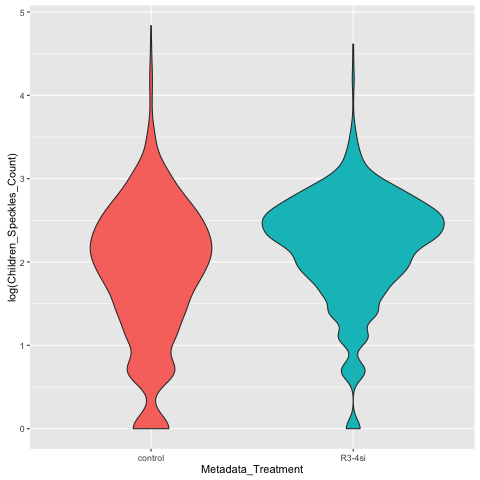

In [110]:
%%R
library(ggplot2)

plot.sp.c=ggplot() 
plot.sp.c= plot.sp.c+geom_violin(data=df_sn,aes(x=Metadata_Treatment,y=log(Children_Speckles_Count) ,fill=factor(Metadata_Treatment)))
plot.sp.c+theme(legend.position='none')+scale_fill_manual(values=c('#F8766D','#00BFC4'))

#ggsave('../Plots/TPX2_violin_Math_AspectRatio_5.pdf')

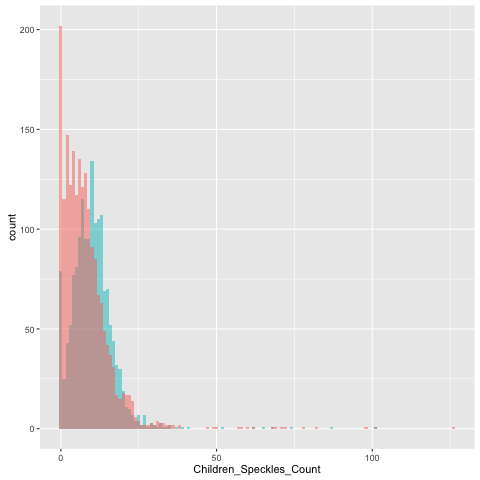

In [111]:
%%R
plot.sp.hist = ggplot()
plot.sp.hist = plot.sp.hist + geom_histogram(data=df_sn[df_sn[,'Metadata_Treatment']=="R3-4si",], aes(x=Children_Speckles_Count), binwidth = 1, fill='#00BFC4', alpha=0.5)
plot.sp.hist = plot.sp.hist + geom_histogram(data=df_sn[df_sn[,'Metadata_Treatment']!="R3-4si",], aes(x=Children_Speckles_Count), binwidth = 1, fill='#F8766D', alpha=0.5)

plot.sp.hist

Are the two different?

In R implementation KS test [does not deal well with discrete distributions](http://davetang.org/muse/2012/04/17/comparing-different-distributions/). The main reason for this are ties (non-unique values).

In [112]:
%%R
y=df_sn[df_sn[,'Metadata_Treatment']=="R3-4si",]$Children_Speckles_Count
x=df_sn[df_sn[,'Metadata_Treatment']!="R3-4si",]$Children_Speckles_Count
ks.test(x,y)


	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.21599, p-value < 2.2e-16
alternative hypothesis: two-sided



As it is count data, it should follow Poisson distribution (p. 237, p. 250). See also count data in the R book.

In [113]:
%%R 
#print(table(df_sn$Children_Speckles_Count))
print('knockdown:')
print(table(df_sn[df_sn[,'Metadata_Treatment']=="R3-4si",]$Children_Speckles_Count))
print('control:')
print(table(df_sn[df_sn[,'Metadata_Treatment']!="R3-4si",]$Children_Speckles_Count))

[1] "knockdown:"

  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19 
 79  25  43  52  77  81  96 115  95  95 134 103 105 107  69  70  52  44  32  30 
 20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  37  39  41  52 
 19  11  10   7   4   7   2   7   1   3   2   1   3   1   1   2   1   1   1   1 
 62  65  68  74  87 101 
  1   1   1   1   1   1 
[1] "control:"

  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19 
202 115 147 122 139 117 135 121 128 110  91  85  67  63  49  42  37  31  17  15 
 20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  38  47  49 
 18  17  17  14   6   4   2   2   2   3   2   4   3   3   2   2   2   2   1   1 
 50  57  58  60  62  68  69  71  72  78  82  98 101 126 
  1   1   1   1   1   1   1   1   1   1   1   1   1   1 


The assumption behind Poisson, though, is that mean = variance. This is not the case here. 

In [114]:
%%R
print(tapply(df_sn$Children_Speckles_Count, df_sn$Metadata_Treatment, mean))
print(tapply(df_sn$Children_Speckles_Count, df_sn$Metadata_Treatment, var))

  control    R3-4si 
 8.085977 10.289028 
 control   R3-4si 
76.72788 53.12281 


In [115]:
%%R
tapply(df_sn$Children_Speckles_Count, df_sn$Metadata_Treatment, var)[1]/tapply(df_sn$Children_Speckles_Count, df_sn$Metadata_Treatment, mean)[1]

 control 
9.489005 


In [116]:
%%R
tapply(df_sn$Children_Speckles_Count, df_sn$Metadata_Treatment, var)[2]/tapply(df_sn$Children_Speckles_Count, df_sn$Metadata_Treatment, mean)[2]

  R3-4si 
5.163054 


The above show that in both cases the data is overdispersed.

In [117]:
%%R
print(length(x))
print(length(y))

[1] 1954
[1] 1595


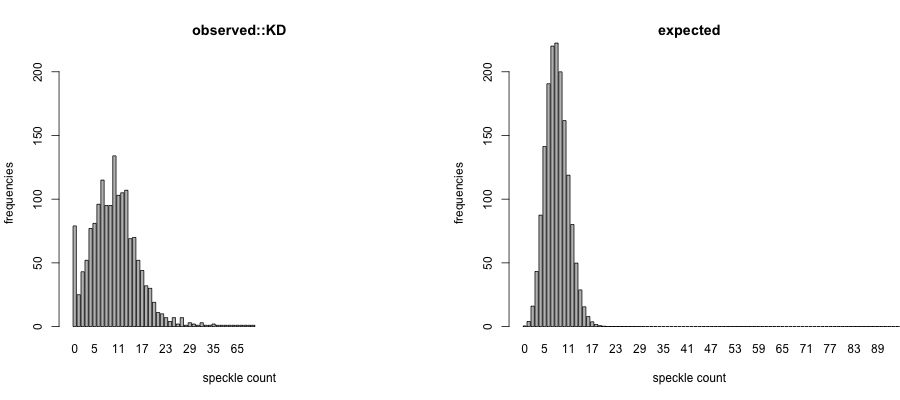

In [118]:
%%R -w 900 -h 400 -u px
par(mfrow=c(1,2))

barplot(table(df_sn[df_sn[,'Metadata_Treatment']=="R3-4si",]$Children_Speckles_Count), ylim=c(0,210),ylab = 'frequencies', xlab = 'speckle count', main = 'observed::KD', xlim=c(0,101))
barplot(dpois(0:101,8.085977)*1595, xlim=c(0,101), ylim=c(0,210),names=as.character(0:101),ylab = 'frequencies', xlab = 'speckle count', main = 'expected')

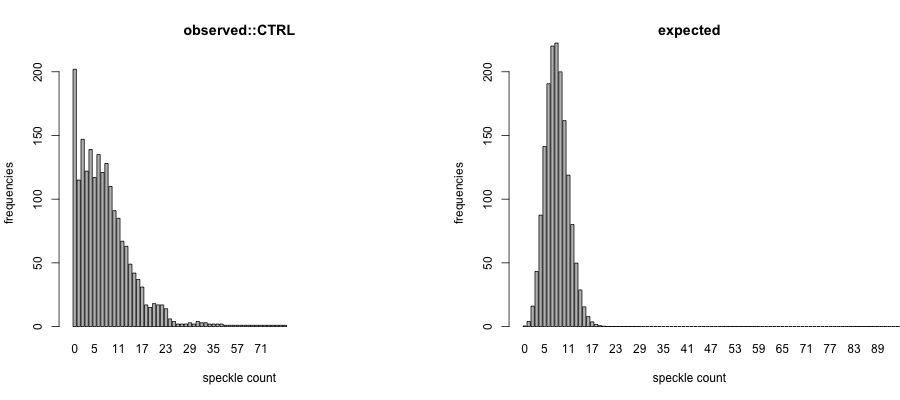

In [119]:
%%R -w 900 -h 400 -u px
par(mfrow=c(1,2))

barplot(table(df_sn[df_sn[,'Metadata_Treatment']!="R3-4si",]$Children_Speckles_Count), ylim=c(0,210),ylab = 'frequencies', xlab = 'speckle count', main = 'observed::CTRL', xlim=c(0,101))
barplot(dpois(0:101,8.085977)*1595, xlim=c(0,101), ylim=c(0,210),names=as.character(0:101),ylab = 'frequencies', xlab = 'speckle count', main = 'expected')

Is the negative binomial better?

[1] 0.9525236


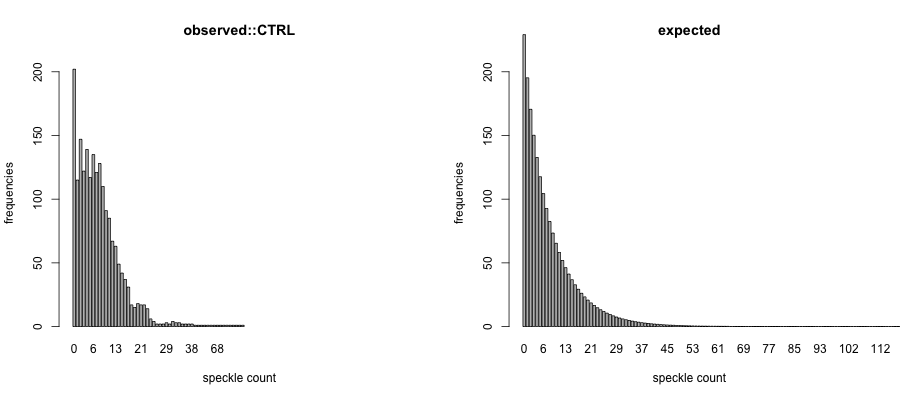

In [120]:
%%R -w 900 -h 400 -u px
par(mfrow=c(1,2))

k.ctrl=mean(df_sn[df_sn[,'Metadata_Treatment']!="R3-4si",]$Children_Speckles_Count)^2/(var(df_sn[df_sn[,'Metadata_Treatment']!="R3-4si",]$Children_Speckles_Count)-mean(df_sn[df_sn[,'Metadata_Treatment']!="R3-4si",]$Children_Speckles_Count))
print(k.ctrl)
expected.ctrl = dnbinom(0:126,size=k.ctrl,mu=8.085977)*1954 
barplot(table(df_sn[df_sn[,'Metadata_Treatment']!="R3-4si",]$Children_Speckles_Count), ylim=c(0,210),ylab = 'frequencies', xlab = 'speckle count', main = 'observed::CTRL', xlim=c(0,126))
barplot(expected.ctrl , xlim=c(0,126), ylim=c(0,210),names=as.character(0:126),ylab = 'frequencies', xlab = 'speckle count', main = 'expected')


[1] 1.542266


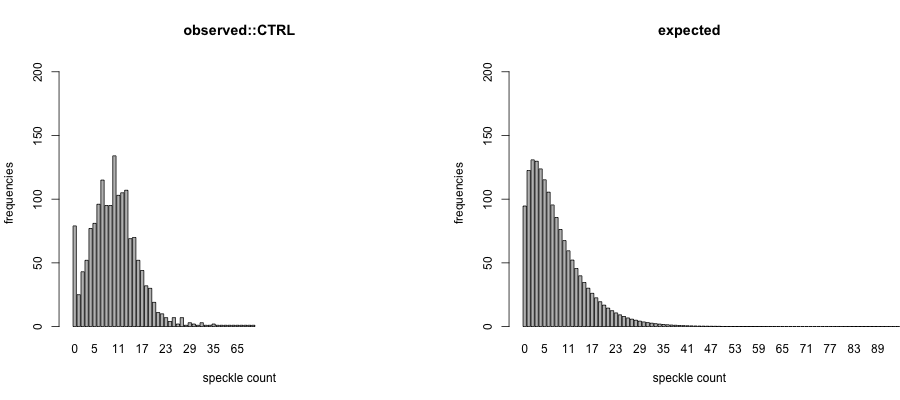

In [121]:
%%R -w 900 -h 400 -u px
par(mfrow=c(1,2))

k.kd=mean(df_sn[df_sn[,'Metadata_Treatment']=="R3-4si",]$Children_Speckles_Count)^2/(var(df_sn[df_sn[,'Metadata_Treatment']!="R3-4si",]$Children_Speckles_Count)-mean(df_sn[df_sn[,'Metadata_Treatment']!="R3-4si",]$Children_Speckles_Count))
print(k.kd)
expected.kd = dnbinom(0:101,size=k.kd,mu=8.085977)*1595  
barplot(table(df_sn[df_sn[,'Metadata_Treatment']=="R3-4si",]$Children_Speckles_Count), ylim=c(0,210),ylab = 'frequencies', xlab = 'speckle count', main = 'observed::CTRL', xlim=c(0,101))
barplot(expected.kd , xlim=c(0,101), ylim=c(0,210),names=as.character(0:101),ylab = 'frequencies', xlab = 'speckle count', main = 'expected')

In [122]:
%%R 
expected.kd

  [1] 9.463702e+01 1.225761e+02 1.308526e+02 1.297561e+02 1.237445e+02
  [6] 1.151937e+02 1.054851e+02 9.545097e+01 8.559510e+01 7.621551e+01
 [11] 6.747809e+01 5.946298e+01 5.219475e+01 4.566256e+01 3.983362e+01
 [16] 3.466238e+01 3.009669e+01 2.608201e+01 2.256404e+01 1.949053e+01
 [21] 1.681231e+01 1.448388e+01 1.246365e+01 1.071399e+01 9.201105e+00
 [26] 7.894867e+00 6.768539e+00 5.798508e+00 4.964004e+00 4.246816e+00
 [31] 3.631022e+00 3.102741e+00 2.649896e+00 2.262000e+00 1.929968e+00
 [36] 1.645934e+00 1.403108e+00 1.195625e+00 1.018437e+00 8.671948e-01
 [41] 7.381594e-01 6.281190e-01 5.343166e-01 4.543878e-01 3.863063e-01
 [46] 3.283366e-01 2.789938e-01 2.370074e-01 2.012919e-01 1.709194e-01
 [51] 1.450981e-01 1.231517e-01 1.045036e-01 8.866201e-02 7.520772e-02
 [56] 6.378357e-02 5.408532e-02 4.585397e-02 3.886905e-02 3.294297e-02
 [61] 2.791616e-02 2.365292e-02 2.003789e-02 1.697304e-02 1.437505e-02
 [66] 1.217315e-02 1.030723e-02 8.726262e-03 7.386918e-03 6.252424e-03
 [71] 

Analysis of deviance (unexplained variation):

In [123]:
%%R
m.1.simple = glm(df_sn$Children_Speckles_Count ~ df_sn$Metadata_Treatment, family=poisson)
summary(m.1.simple)


Call:
glm(formula = df_sn$Children_Speckles_Count ~ df_sn$Metadata_Treatment, 
    family = poisson)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-4.536  -1.833  -0.391   0.971  21.359  

Coefficients:
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                    2.090131   0.007956  262.73   <2e-16 ***
df_sn$Metadata_TreatmentR3-4si 0.240947   0.011146   21.62   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 21119  on 3548  degrees of freedom
Residual deviance: 20652  on 3547  degrees of freedom
AIC: 33372

Number of Fisher Scoring iterations: 5



Residual deviance (20652) is much greater than the residual degrees of freedom (3547) indicating substantial overdisperssion (greater variability in data than what would be expected given the model).

In [124]:
%%R
m.2.simple = glm(df_sn$Children_Speckles_Count ~ df_sn$Metadata_Treatment, family=quasipoisson)
summary(m.2.simple)


Call:
glm(formula = df_sn$Children_Speckles_Count ~ df_sn$Metadata_Treatment, 
    family = quasipoisson)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-4.536  -1.833  -0.391   0.971  21.359  

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     2.09013    0.02185   95.65  < 2e-16 ***
df_sn$Metadata_TreatmentR3-4si  0.24095    0.03062    7.87 4.67e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for quasipoisson family taken to be 7.544968)

    Null deviance: 21119  on 3548  degrees of freedom
Residual deviance: 20652  on 3547  degrees of freedom
AIC: NA

Number of Fisher Scoring iterations: 5



In [125]:
%%R
library(MASS)
df.mod = as.data.frame(cbind(df_sn$Children_Speckles_Count,df_sn$Metadata_Treatment))
#step required: http://stackoverflow.com/questions/16985965/non-comformable-arrays-error-when-using-xts-series-in-a-logistic-regression

In [126]:
%%R
library(MASS)
m.3.simple = glm.nb(V1 ~ V2, data = df.mod)
summary(m.3.simple, cor = F)


Call:
glm.nb(formula = V1 ~ V2, data = df.mod, init.theta = 1.724648672, 
    link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5875  -0.7667  -0.1586   0.3900   6.0367  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.84918    0.04318  42.824   <2e-16 ***
V2           0.24095    0.02801   8.603   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(1.7246) family taken to be 1)

    Null deviance: 4203.0  on 3548  degrees of freedom
Residual deviance: 4128.7  on 3547  degrees of freedom
AIC: 22758

Number of Fisher Scoring iterations: 1


              Theta:  1.7246 
          Std. Err.:  0.0511 

 2 x log-likelihood:  -22752.1540 


[Testing negative binomial against Poisson in a likelihood ratio test](http://stats.stackexchange.com/questions/49614/comparing-two-vectors-from-negative-binomial-distribution-in-r).

In [127]:
%%R
library(pscl)
odTest(m.3.simple)

/Users/andi/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Classes and Methods for R developed in the


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/andi/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Political Science Computational Laboratory


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/andi/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Department of Political Science


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/andi/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Stanford University


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/andi/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Simon Jackman


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/andi/anaconda/lib/python2.7/site-packages

Likelihood ratio test of H0: Poisson, as restricted NB model:
n.b., the distribution of the test-statistic under H0 is non-standard
e.g., see help(odTest) for details/references

Critical value of test statistic at the alpha= 0.05 level: 2.7055 
Chi-Square Test Statistic =  10615.4164 p-value = < 2.2e-16 


[Additional details on fitting discrete distributions](http://stats.stackexchange.com/questions/66192/how-to-fit-a-discrete-distribution-to-count-data)

## ADD: other categorical variables for the analysis of deviance and run step-wise reduction of the model.

Does the speckle count correlate with any of the texture descriptors?

Lamin to internal signal ratio?

Internal signal per se?

### AWG favorite variables

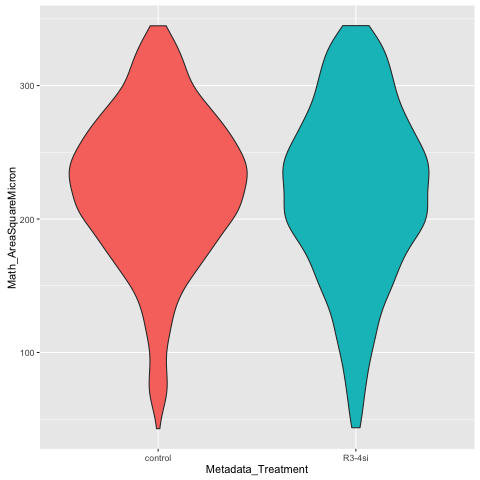

In [128]:
%%R
library(ggplot2)
#Math_AreaSquareMicron 
plot.1.m=ggplot() 
plot.1.m = plot.1.m+geom_violin(data=df_n,aes(x=Metadata_Treatment,y=Math_AreaSquareMicron ,fill=factor(Metadata_Treatment)))
plot.1.m+theme(legend.position='none')+scale_fill_manual(values=c('#F8766D','#00BFC4'))

#ggsave('../Plots/TPX2_violin_Math_AspectRatio_5.pdf')

In [129]:
pattern = re.compile('.*Area.*',re.IGNORECASE)

In [130]:
[re.match(pattern, colName).group() for colName in df_n.columns.tolist() if re.match(pattern, colName) != None]

['AreaShape_Area',
 'AreaShape_Center_X',
 'AreaShape_Center_Y',
 'AreaShape_Compactness',
 'AreaShape_Eccentricity',
 'AreaShape_EulerNumber',
 'AreaShape_Extent',
 'AreaShape_FormFactor',
 'AreaShape_MajorAxisLength',
 'AreaShape_MaxFeretDiameter',
 'AreaShape_MaximumRadius',
 'AreaShape_MeanRadius',
 'AreaShape_MedianRadius',
 'AreaShape_MinFeretDiameter',
 'AreaShape_MinorAxisLength',
 'AreaShape_Orientation',
 'AreaShape_Perimeter',
 'AreaShape_Solidity',
 'AreaShape_Zernike_0_0',
 'AreaShape_Zernike_1_1',
 'AreaShape_Zernike_2_0',
 'AreaShape_Zernike_2_2',
 'AreaShape_Zernike_3_1',
 'AreaShape_Zernike_3_3',
 'AreaShape_Zernike_4_0',
 'AreaShape_Zernike_4_2',
 'AreaShape_Zernike_4_4',
 'AreaShape_Zernike_5_1',
 'AreaShape_Zernike_5_3',
 'AreaShape_Zernike_5_5',
 'AreaShape_Zernike_6_0',
 'AreaShape_Zernike_6_2',
 'AreaShape_Zernike_6_4',
 'AreaShape_Zernike_6_6',
 'AreaShape_Zernike_7_1',
 'AreaShape_Zernike_7_3',
 'AreaShape_Zernike_7_5',
 'AreaShape_Zernike_7_7',
 'AreaShape_Zer

In [131]:
pattern = re.compile('.*texture.*',re.IGNORECASE)
[re.match(pattern, colName).group() for colName in df_n.columns.tolist() if re.match(pattern, colName) != None]

['Texture_AngularSecondMoment_RawInput_10_0',
 'Texture_AngularSecondMoment_RawInput_10_90',
 'Texture_AngularSecondMoment_RawInput_5_0',
 'Texture_AngularSecondMoment_RawInput_5_90',
 'Texture_Contrast_RawInput_10_0',
 'Texture_Contrast_RawInput_10_90',
 'Texture_Contrast_RawInput_5_0',
 'Texture_Contrast_RawInput_5_90',
 'Texture_Correlation_RawInput_10_0',
 'Texture_Correlation_RawInput_10_90',
 'Texture_Correlation_RawInput_5_0',
 'Texture_Correlation_RawInput_5_90',
 'Texture_DifferenceEntropy_RawInput_10_0',
 'Texture_DifferenceEntropy_RawInput_10_90',
 'Texture_DifferenceEntropy_RawInput_5_0',
 'Texture_DifferenceEntropy_RawInput_5_90',
 'Texture_DifferenceVariance_RawInput_10_0',
 'Texture_DifferenceVariance_RawInput_10_90',
 'Texture_DifferenceVariance_RawInput_5_0',
 'Texture_DifferenceVariance_RawInput_5_90',
 'Texture_Entropy_RawInput_10_0',
 'Texture_Entropy_RawInput_10_90',
 'Texture_Entropy_RawInput_5_0',
 'Texture_Entropy_RawInput_5_90',
 'Texture_InfoMeas1_RawInput_10_

In [132]:
pattern = re.compile('.*area.*',re.IGNORECASE)
[re.match(pattern, colName).group() for colName in df_n.columns.tolist() if re.match(pattern, colName) != None]

['AreaShape_Area',
 'AreaShape_Center_X',
 'AreaShape_Center_Y',
 'AreaShape_Compactness',
 'AreaShape_Eccentricity',
 'AreaShape_EulerNumber',
 'AreaShape_Extent',
 'AreaShape_FormFactor',
 'AreaShape_MajorAxisLength',
 'AreaShape_MaxFeretDiameter',
 'AreaShape_MaximumRadius',
 'AreaShape_MeanRadius',
 'AreaShape_MedianRadius',
 'AreaShape_MinFeretDiameter',
 'AreaShape_MinorAxisLength',
 'AreaShape_Orientation',
 'AreaShape_Perimeter',
 'AreaShape_Solidity',
 'AreaShape_Zernike_0_0',
 'AreaShape_Zernike_1_1',
 'AreaShape_Zernike_2_0',
 'AreaShape_Zernike_2_2',
 'AreaShape_Zernike_3_1',
 'AreaShape_Zernike_3_3',
 'AreaShape_Zernike_4_0',
 'AreaShape_Zernike_4_2',
 'AreaShape_Zernike_4_4',
 'AreaShape_Zernike_5_1',
 'AreaShape_Zernike_5_3',
 'AreaShape_Zernike_5_5',
 'AreaShape_Zernike_6_0',
 'AreaShape_Zernike_6_2',
 'AreaShape_Zernike_6_4',
 'AreaShape_Zernike_6_6',
 'AreaShape_Zernike_7_1',
 'AreaShape_Zernike_7_3',
 'AreaShape_Zernike_7_5',
 'AreaShape_Zernike_7_7',
 'AreaShape_Zer

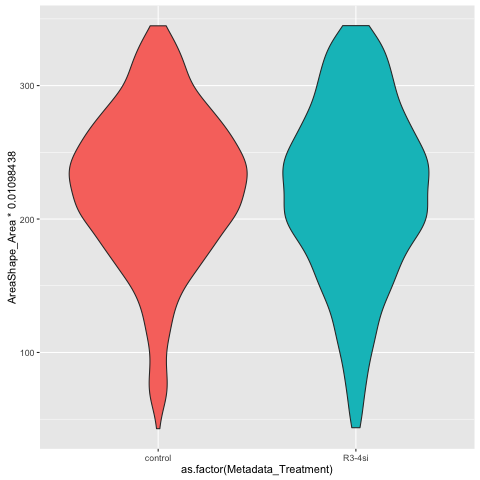

In [133]:
%%R
#Math_AreaSquareMicron 
plot.1.a=ggplot() 
plot.1.a = plot.1.a+geom_violin(data=df_n,aes(x=as.factor(Metadata_Treatment),y=AreaShape_Area*0.01098438 ,fill=factor(Metadata_Treatment)))
plot.1.a+theme(legend.position='none')+scale_fill_manual(values=c('#F8766D','#00BFC4'))

#ggsave('../Plots/Nuclei_Area_orig.pdf')

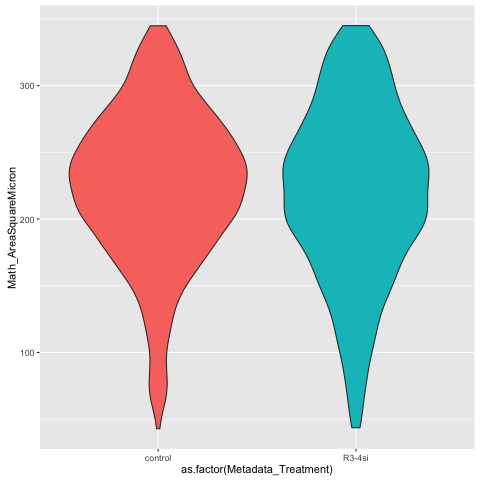

In [134]:
%%R
#Math_AreaSquareMicron 
plot.1.a=ggplot() 
plot.1.a = plot.1.a+geom_violin(data=df_n,aes(x=as.factor(Metadata_Treatment),y=Math_AreaSquareMicron ,fill=factor(Metadata_Treatment)))
plot.1.a+theme(legend.position='none')+scale_fill_manual(values=c('#F8766D','#00BFC4'))

#plot.1 = plot.1+geom_violin(data=df_cont,aes(x=Metadata_Treatment,y=1/Math_AspectRatio ,fill=factor(Metadata_Treatment)))
#plot.1+theme(legend.position='none')+scale_fill_manual(values=c('#7F7F7F','#179B33'))

#ggsave('../Plots/Nuclei_Area_alternative.pdf')

In [135]:
%%R
length(df_n)

[1] 155


As we don't know a priori which variables are different, we will correct for multiple comparisons. The n for BH correction will be the number of numerical variables in the dataset. See above.

In [136]:
%%R
C=df_n[df_n$Metadata_Treatment!='R3-4si',]$Math_AreaSquareMicron
E=df_n[df_n$Metadata_Treatment=='R3-4si',]$Math_AreaSquareMicron
#plot(seq(0,1,length=length(C)), cumsum(sort(C)/sum(C)),type='l',col='blue',ylab='cumulative probability',xlab='index')
#lines( seq(0,1,length=length(E)), cumsum(sort(E)/sum(E)), col='red')
#print(ks.test(df_no_centers[df_no_centers$Metadata_Treatment==0,]$Euclidian_norm_centers,df_no_centers[df_no_centers$Metadata_Treatment!=0,]$Euclidian_norm_centers,))
print(ks.test(C,E)[[2]])
print(p.adjust(ks.test(C,E)[[2]], method = "BH", n=140))

[1] 0.0004227373
[1] 0.05918322


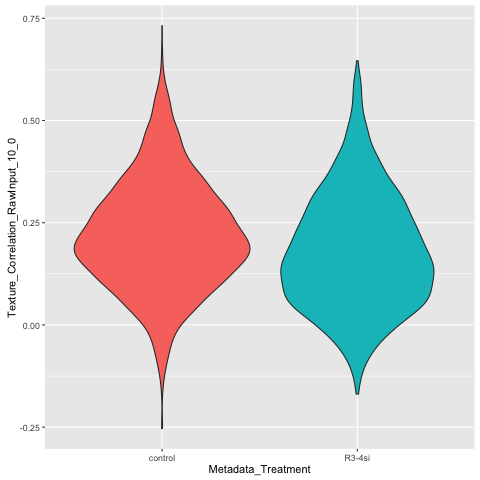

In [137]:
%%R
library(ggplot2)
#Texture_Correlation_RawInput_10_0
plot.2.m=ggplot() 
plot.2.m = plot.2.m+geom_violin(data=df_n,aes(x=Metadata_Treatment,y=Texture_Correlation_RawInput_10_0 ,fill=factor(Metadata_Treatment)))
plot.2.m+theme(legend.position='none')+scale_fill_manual(values=c('#F8766D','#00BFC4'))

#ggsave('../Plots/Nuclei_Texture_Correlation_RawInput_10_0_alternative.pdf')

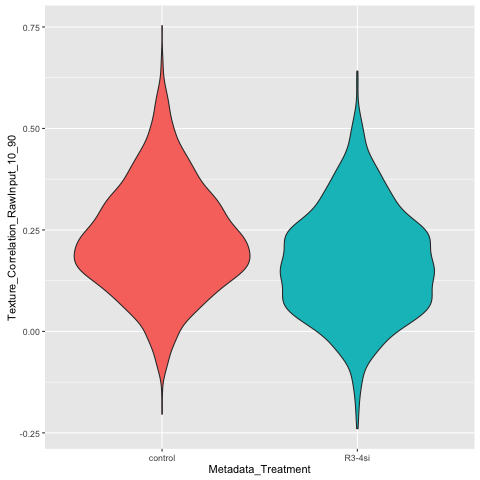

In [138]:
%%R
library(ggplot2)
#Math_AreaSquareMicron 
plot.2.m=ggplot() 
plot.2.m = plot.2.m+geom_violin(data=df_n,aes(x=Metadata_Treatment,y=Texture_Correlation_RawInput_10_90 ,fill=factor(Metadata_Treatment)))
plot.2.m+theme(legend.position='none')+scale_fill_manual(values=c('#F8766D','#00BFC4'))
#ggsave('../Plots/Texture_Correlation_RawInput_10_90_alternative.pdf')

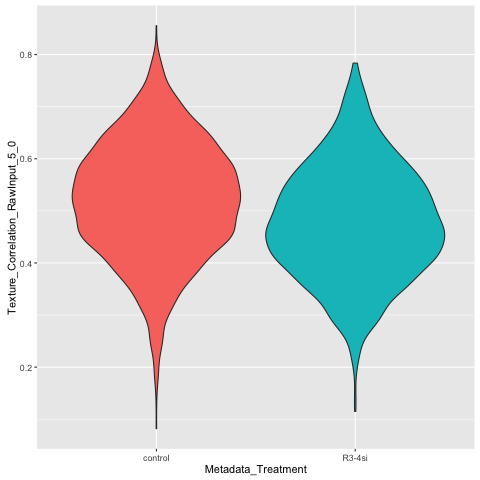

In [139]:
%%R
library(ggplot2)
#Texture_Correlation_RawInput_5_0
plot.2.m=ggplot() 
plot.2.m = plot.2.m+geom_violin(data=df_n,aes(x=Metadata_Treatment,y=Texture_Correlation_RawInput_5_0 ,fill=factor(Metadata_Treatment)))
plot.2.m+theme(legend.position='none')+scale_fill_manual(values=c('#F8766D','#00BFC4'))
#ggsave('../Plots/Texture_Correlation_RawInput_5_0_alternative.pdf')

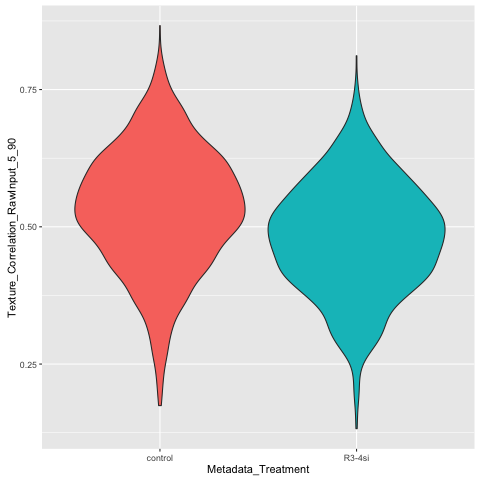

In [140]:
%%R
library(ggplot2)
#Texture_Correlation_RawInput_5_90 
plot.2.m=ggplot() 
plot.2.m = plot.2.m+geom_violin(data=df_n,aes(x=Metadata_Treatment,y=Texture_Correlation_RawInput_5_90 ,fill=factor(Metadata_Treatment)))
plot.2.m+theme(legend.position='none')+scale_fill_manual(values=c('#F8766D','#00BFC4'))
#ggsave('../Plots/Texture_Correlation_RawInput_5_90_alternative.pdf')

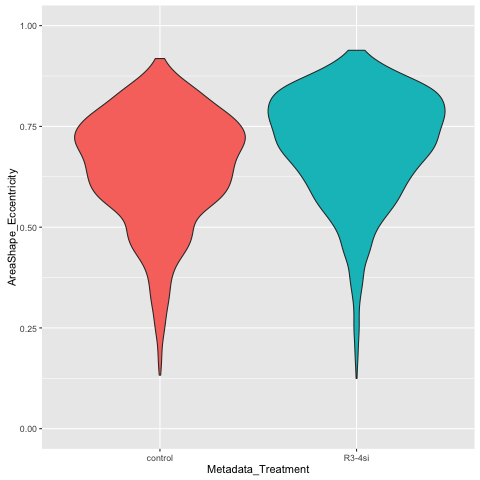

In [141]:
%%R
library(ggplot2)
#AreaShape_Eccentricity
plot.2.m=ggplot() 
plot.2.m = plot.2.m+geom_violin(data=df_n,aes(x=Metadata_Treatment,y=AreaShape_Eccentricity ,fill=factor(Metadata_Treatment)))
plot.2.m+theme(legend.position='none')+scale_fill_manual(values=c('#F8766D','#00BFC4'))+ylim(0.0,1.0)
#ggsave('../Plots/Nuclei_AreaShape_Eccentricity_alternative.pdf')

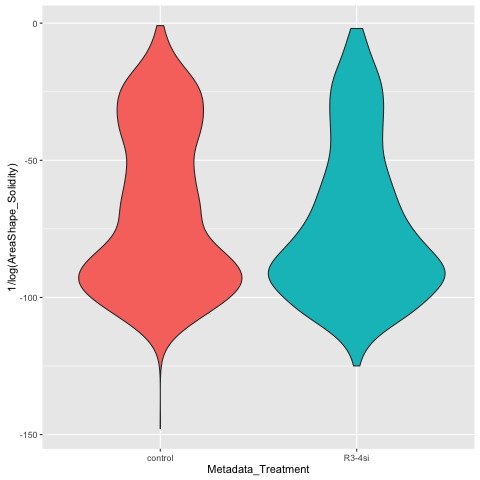

In [142]:
%%R
library(ggplot2)
#1/log(AreaShape_Solidity 
plot.2.m=ggplot() 
plot.2.m = plot.2.m+geom_violin(data=df_n,aes(x=Metadata_Treatment,y=1/log(AreaShape_Solidity) ,fill=factor(Metadata_Treatment)))
plot.2.m+theme(legend.position='none')+scale_fill_manual(values=c('#F8766D','#00BFC4'))

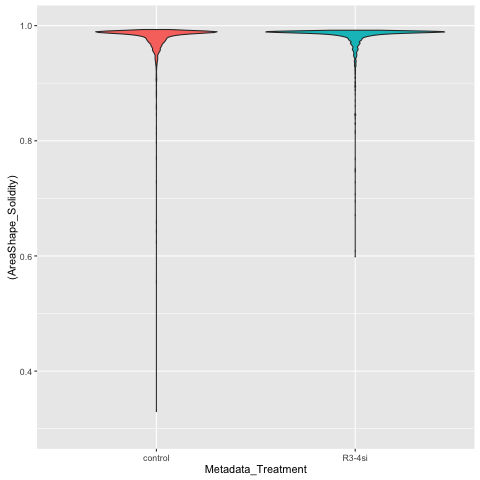

In [143]:
%%R
library(ggplot2)
#AreaShape_Solidity
plot.2.m=ggplot() 
plot.2.m = plot.2.m+geom_violin(data=df_n,aes(x=Metadata_Treatment,y=(AreaShape_Solidity) ,fill=factor(Metadata_Treatment)))
plot.2.m+theme(legend.position='none')+scale_fill_manual(values=c('#F8766D','#00BFC4')) + ylim(0.3,1.0)
#ggsave('../Plots/Nuclei_AreaShape_Solidity_alternative.pdf')

In [144]:
%%R
C=df_n[df_n$Metadata_Treatment!='R3-4si',]$AreaShape_Solidity
E=df_n[df_n$Metadata_Treatment=='R3-4si',]$AreaShape_Solidity
#plot(seq(0,1,length=length(C)), cumsum(sort(C)/sum(C)),type='l',col='blue',ylab='cumulative probability',xlab='index')
#lines( seq(0,1,length=length(E)), cumsum(sort(E)/sum(E)), col='red')
#print(ks.test(df_no_centers[df_no_centers$Metadata_Treatment==0,]$Euclidian_norm_centers,df_no_centers[df_no_centers$Metadata_Treatment!=0,]$Euclidian_norm_centers,))
print(ks.test(C,E))


	Two-sample Kolmogorov-Smirnov test

data:  C and E
D = 0.096024, p-value = 1.853e-07
alternative hypothesis: two-sided



# IV. Data tranformation for modelling


Requires transforming data to normal like, centering and scaling. We'll use a maximum likelihood estimation of the transformation parameter.     
<a name='IV' /a>   
<a href=#Data2R>Data loaded to R.</a>   
<a href=#Top>Top</a>


## Remove zero-variance variables    


This step is also done before.

In [145]:
%%R
nzv_n = nearZeroVar(df_n_num_, saveMetrics = TRUE)

In [146]:
%%R
nzv_n[nzv_n$nzv,]

                                                      freqRatio percentUnique
AreaShape_EulerNumber                                   0.00000    0.02817695
Intensity_LowerQuartileIntensity_ImageAfterMathLamina 208.62500    0.92983939
Intensity_MaxIntensity_ImageAfterMathLamina            58.55882    5.71992110
Intensity_MaxIntensity_RawInput                        64.46875    5.60721330
Intensity_MinIntensity_ImageAfterMathLamina             0.00000    0.02817695
                                                      zeroVar  nzv
AreaShape_EulerNumber                                    TRUE TRUE
Intensity_LowerQuartileIntensity_ImageAfterMathLamina   FALSE TRUE
Intensity_MaxIntensity_ImageAfterMathLamina             FALSE TRUE
Intensity_MaxIntensity_RawInput                         FALSE TRUE
Intensity_MinIntensity_ImageAfterMathLamina              TRUE TRUE


In [147]:
%%R
nzv_n = nearZeroVar(df_n_num_)
df_n_num_nzv = as.data.frame(df_n_num_[,-nzv_n])
print(class(df_n_num_nzv))

[1] "data.frame"


For the filling in the missing values drop the dummy variables.

In [148]:
%%R
df_n_num_nzv_meta_only = df_n_num_nzv[,(length(names(df_n_num_nzv))-2):length(names(df_n_num_nzv))]
df_n_num_nzv_no_meta = df_n_num_nzv[,-((length(names(df_n_num_nzv))-2):length(names(df_n_num_nzv)))]
print(head(df_n_num_nzv[,(length(names(df_n_num_nzv))-2):length(names(df_n_num_nzv))]))
print(names(df_n_num_nzv_no_meta)) #use for transformation and imputation of missing values

  Metadata_ExperimentID.Exp1 Metadata_ExperimentID.Exp2
0                          1                          0
1                          1                          0
2                          1                          0
3                          1                          0
4                          1                          0
5                          1                          0
  Metadata_ExperimentID.Exp3
0                          0
1                          0
2                          0
3                          0
4                          0
5                          0
  [1] "AreaShape_Area"                                        
  [2] "AreaShape_Compactness"                                 
  [3] "AreaShape_Eccentricity"                                
  [4] "AreaShape_Extent"                                      
  [5] "AreaShape_FormFactor"                                  
  [6] "AreaShape_MajorAxisLength"                             
  [7] "AreaShape_MaxFeretDi

Use df_n_num_nzv_no_meta for transformation and imputation of missing values. 

In [149]:
%%R
library(caret)
convert_data_type=function(data_frame){

    for (col in names(data_frame)){
        data_frame[,col]<-as.numeric(data_frame[,col])
    }
    
    return(data_frame)
}

df_n_num=convert_data_type(df_n_num_nzv)
df_n_num=convert_data_type(df_n_num_nzv_no_meta)

#df_sn_num=convert_data_type(df_sn_num)
#df_sp_num =convert_data_type(df_sp_num)


In [150]:
%%R
print(class(df_n_num_nzv))
print(class(df_n_num_nzv_no_meta))
class(df_n_num)

[1] "data.frame"
[1] "data.frame"
[1] "data.frame"


In [151]:
%%R

testDataType = function(data_frame){
    
    for (col in names(data_frame)){
        #print(col)
        #print(class(data_frame[,col]))
        data_frame[,col] <- as.factor(data_frame[,col])
        #print(class(data_frame[,col]))
    }
    
}
#print(metadata_df_nuclei)
testDataType(metadata_df_nuclei)
testDataType(metadata_df_sn)
testDataType(metadata_df_sp)

## Removing skeweness, centering and scaling data.

In [152]:
%%R
trans_n = preProcess(df_n_num_nzv_no_meta, method=c('BoxCox','center','scale'))
#trans_sn = preProcess(df_sn_num, method=c('BoxCox','center','scale'))
#trans_sp = preProcess(df_sp_num, method=c('BoxCox','center','scale'))

In [153]:
%%R
df_n_num_nzv_no_meta_trans = predict(trans_n, df_n_num_nzv_no_meta)
#df_sn_num_trans = predict(trans_sn, df_sn_num)
#df_sp_num_trans = predict(trans_sp, df_sp_num)

Before tranformation:

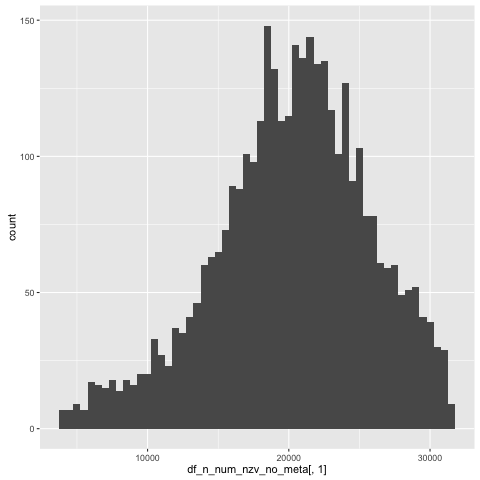

In [154]:
%%R
p=ggplot()
p+geom_histogram(aes(df_n_num_nzv_no_meta[,1]), binwidth=500)

After transformation:

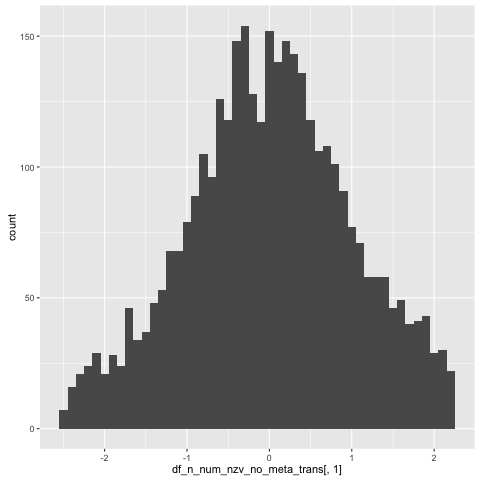

In [155]:
%%R
class(df_n_num_nzv_no_meta_trans)
p = ggplot()
p+geom_histogram(aes(df_n_num_nzv_no_meta_trans[,1]), binwidth=0.1)

#hist(df_n_num_nzv_no_meta_trans[,1])

## Missing values

Getting data back to Python.

In [156]:
%R -o df_n_num_nzv_no_meta_trans

In [157]:
df_n_num_nzv_no_meta_trans.shape

(3549, 130)

In [158]:
np.sum(np.sum(df_n_num_nzv_no_meta_trans.isnull()==True))

281

The fraction of missing values:

In [159]:
(281.0/(df_n_num_nzv_no_meta_trans.shape[0]*df_n_num_nzv_no_meta_trans.shape[1]))*100

0.060905563864143746

In [160]:
np.sum(df_n_num_nzv_no_meta_trans.isnull()==True)[np.sum(df_n_num_nzv_no_meta_trans.isnull()==True) != 0]

Math_TotalSpeckleToNucleusArea    281
dtype: int64

Create mapping data frame (binary):

In [161]:
M_mapping_notnull = df_n_num_nzv_no_meta_trans.notnull()

In [162]:
M_mapping_notnull.values[0:5, 0:5]

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]], dtype=bool)

In [163]:
M_mapping_null = df_n_num_nzv_no_meta_trans.isnull()

In [164]:
M_mapping_null.values[0:5, 0:5]

array([[False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]], dtype=bool)

Fill NA with median of all values (here, it does not matter what it is, but it's better if it is close to what the expected value will be).

In [165]:
df_n_num_nzv_no_meta_trans_filled = df_n_num_nzv_no_meta_trans.fillna(df_n_num_nzv_no_meta_trans.median())

In [166]:
np.sum(np.sum(df_n_num_nzv_no_meta_trans_filled.isnull()==True))

0

Above shows that there are no more NAs in the data frame. We will use it for svd now (it is not a sparse svd as we only have a small number of missing values; see above: 0.06%).

References: [here](https://dgleich.wordpress.com/2013/10/25/svd-on-the-netflix-matrix-part-2/) and [here](https://dgleich.wordpress.com/2013/10/19/svd-on-the-netflix-matrix/). [Reference code in Matlab and Python](https://gist.github.com/dgleich/7049908). Using recommendation from [here on SO](http://stackoverflow.com/questions/24913232/using-numpy-np-linalg-svd-for-singular-value-decomposition). Reference on [numpy](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.linalg.svd.html).

In [167]:
U, s, V = np.linalg.svd(df_n_num_nzv_no_meta_trans_filled, full_matrices=False)

In [168]:
df_n_num_nzv_no_meta_trans_filled.shape, U.shape, s.shape, V.shape

((3549, 130), (3549, 130), (130,), (130, 130))

Reconstruction based on full svd.

In [169]:
X_a = np.dot(U, np.dot(np.diag(s), V))

Testing how well the reconstruction worked.

In [170]:
np.allclose(df_n_num_nzv_no_meta_trans_filled, X_a)

True

In [171]:
np.std(df_n_num_nzv_no_meta_trans_filled.values), np.std(X_a), np.std(df_n_num_nzv_no_meta_trans_filled.values-X_a)

(0.99955580328945237, 0.99955580328945259, 2.1031429584431001e-15)

In [172]:
df_n_num_nzv_no_meta_trans_filled.values[0:3,0:3]

array([[ 1.2342809 , -0.48581888, -0.20160681],
       [-1.20992144,  0.58019745,  0.89260982],
       [-1.2768427 , -0.75584105, -1.05411301]])

In [173]:
X_a[0:3,0:3]

array([[ 1.2342809 , -0.48581888, -0.20160681],
       [-1.20992144,  0.58019745,  0.89260982],
       [-1.2768427 , -0.75584105, -1.05411301]])

Reconstruction of the final dataset:

Suppress all values apart from the original NAs. These are the only values we want to put in into the original data matrix.

In [174]:
X_b = np.multiply(X_a,M_mapping_null.values)

In [175]:
X_b[0:3,0:3]

array([[ 0., -0., -0.],
       [-0.,  0.,  0.],
       [-0., -0., -0.]])

Suppress only the original NAs.

In [176]:
X_c = np.multiply(df_n_num_nzv_no_meta_trans_filled.values, M_mapping_notnull.values)

In [177]:
X_c[0:3,0:3]

array([[ 1.2342809 , -0.48581888, -0.20160681],
       [-1.20992144,  0.58019745,  0.89260982],
       [-1.2768427 , -0.75584105, -1.05411301]])

To get the final dataset, add 

In [178]:
final = np.add(X_b, X_c)

In [179]:
final[0:3,0:3]

array([[ 1.2342809 , -0.48581888, -0.20160681],
       [-1.20992144,  0.58019745,  0.89260982],
       [-1.2768427 , -0.75584105, -1.05411301]])

In [180]:
df_n_num_nzv_no_meta_trans_noNA = pd.DataFrame(final, columns=df_n_num_nzv_no_meta_trans.columns)

In [181]:
%R -i df_n_num_nzv_no_meta_trans_noNA

## Correlated predictors
Checking for correlated predictors.

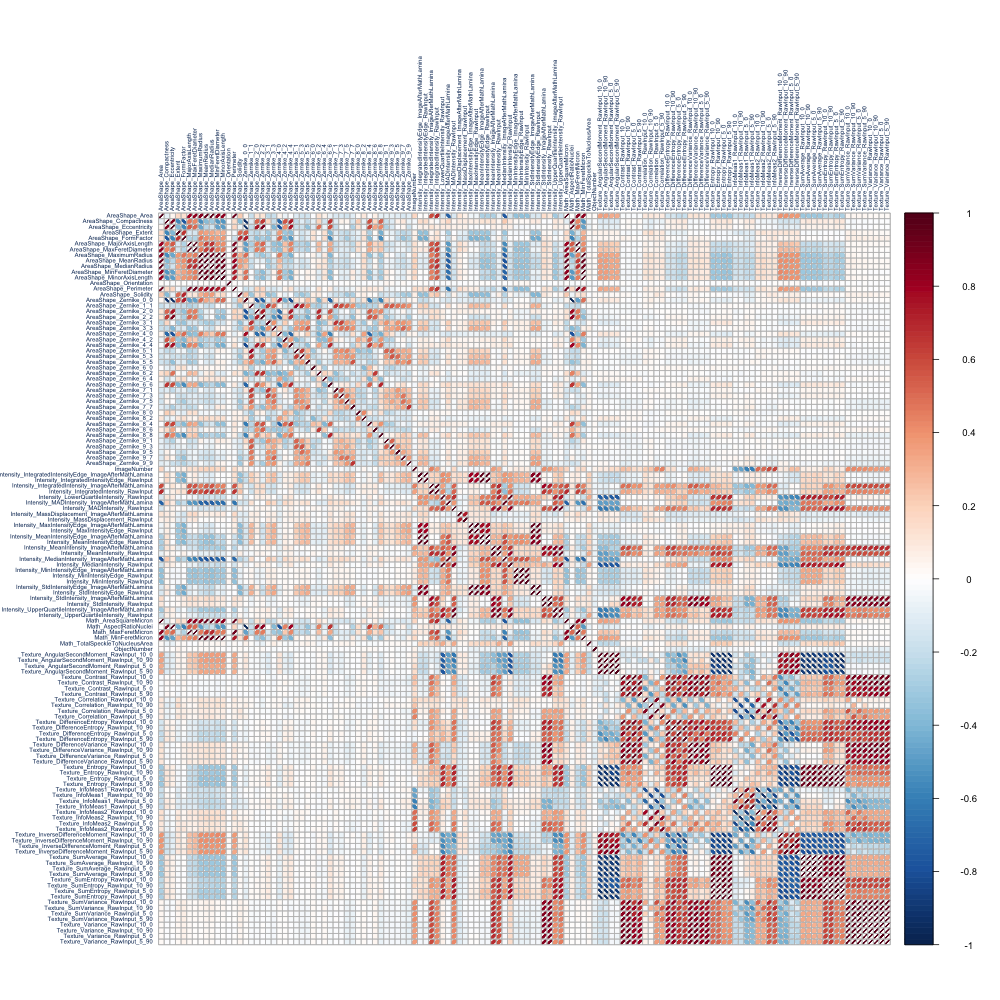

In [182]:
%%R -w 1000 -h 1000 -u px

corr.all=cor(df_n_num_nzv_no_meta_trans_noNA)
col2 <- colorRampPalette(rev(c("#67001F", "#B2182B", "#D6604D", "#F4A582",
                               "#FDDBC7", "#FFFFFF", "#D1E5F0", "#92C5DE", "#4393C3", "#2166AC", "#053061")))


#corr.all
#png('../Plots/TPX2_rcorr_plot.png',width=2000, height=2000)
#par(cex=0.8)
corrplot(corr.all, method='ellipse',col=col2(dim(df_n_num_nzv_no_meta_trans_noNA)[2]),
         tl.col="#053061",tl.cex=0.5)
#dev.off()
#corrplot(corr.all, method='ellipse',col=col2(dim(df_cont.cp)[2]),tl.col="#053061",tl.cex=0.5)


Below we will re-order the way data is plotted to visualize clusters of correlated predictors.

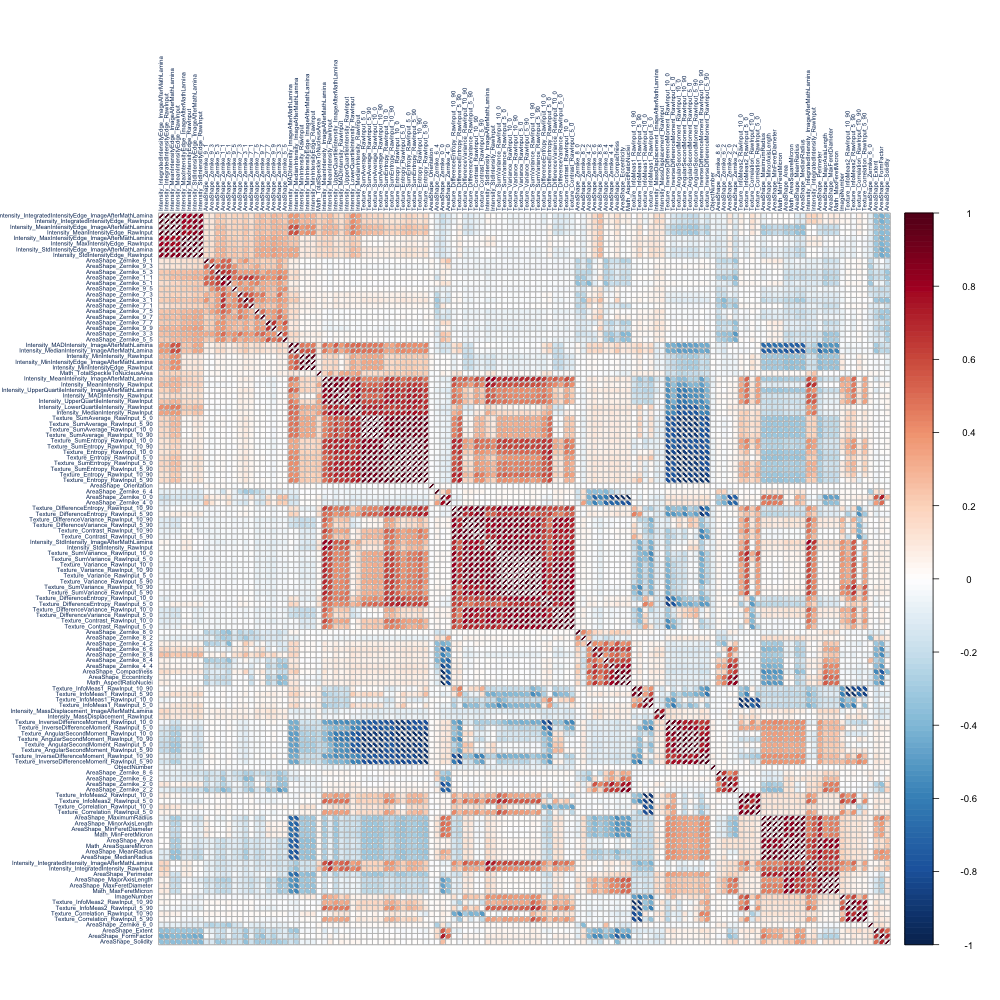

In [183]:
%%R -w 1000 -h 1000 -u px

corr.all=cor(df_n_num_nzv_no_meta_trans_noNA)
col2 <- colorRampPalette(rev(c("#67001F", "#B2182B", "#D6604D", "#F4A582", "#FDDBC7", "#FFFFFF", 
                               "#D1E5F0", "#92C5DE", "#4393C3", "#2166AC", "#053061")))


#corr.all
#png('../Plots/TPX2_rcorr_plot.png',width=2000, height=2000)
#par(cex=0.8)
corrplot(corr.all, method='ellipse',col=col2(dim(df_n_num_nzv_no_meta_trans_noNA)[2]),tl.col="#053061",
         tl.cex=0.5, order="hclust")
#dev.off()
#corrplot(corr.all, method='ellipse',col=col2(dim(df_cont.cp)[2]),tl.col="#053061",tl.cex=0.5)


## Reducing dimensions

[Additional information](http://www.sthda.com/english/wiki/principal-component-analysis-in-r-prcomp-vs-princomp-r-software-and-data-mining#packages-in-r-for-principal-component-analysis) on how what the prcomp object contains and how it can be utilized. The prcomp is using svd for PCA. [Simple and comprehensive intro to PCA](http://www.cs.otago.ac.nz/cosc453/student_tutorials/principal_components.pdf).

In [184]:
%%R
pcaObj = prcomp(df_n_num_nzv_no_meta_trans_noNA, center = FALSE, scale=FALSE)

In [185]:
%%R
pcaObj.2 = prcomp(df_n_num_nzv_no_meta_trans_noNA, center = TRUE, scale=TRUE)

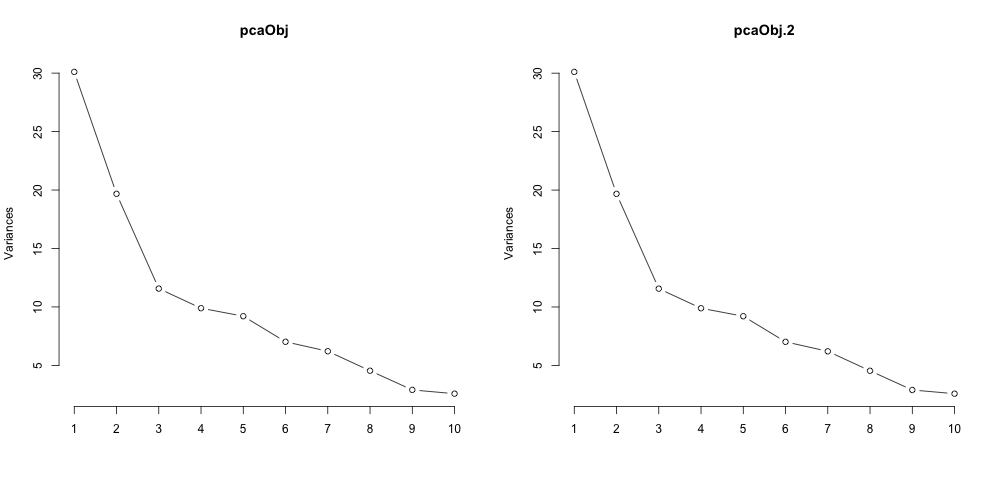

In [186]:
%%R  -w 1000  -u px
par(mfrow=c(1,2))
plot(pcaObj, type='l')
plot(pcaObj.2, type='l')


In [196]:
%%R
print(str(pcaObj))
print(names(pcaObj))

List of 5
 $ sdev    : num [1:130] 5.49 4.44 3.4 3.15 3.03 ...
 $ rotation: num [1:130, 1:130] -0.0585 0.0258 0.0185 -0.0167 -0.0103 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:130] "AreaShape_Area" "AreaShape_Compactness" "AreaShape_Eccentricity" "AreaShape_Extent" ...
  .. ..$ : chr [1:130] "PC1" "PC2" "PC3" "PC4" ...
 $ center  : logi FALSE
 $ scale   : logi FALSE
 $ x       : num [1:3549, 1:130] -10.11 7.42 7.77 3.52 6.9 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:3549] "0" "1" "2" "3" ...
  .. ..$ : chr [1:130] "PC1" "PC2" "PC3" "PC4" ...
 - attr(*, "class")= chr "prcomp"
NULL
[1] "sdev"     "rotation" "center"   "scale"    "x"       


In [197]:
%%R
pcaObj$sdev[1:6]

[1] 5.486695 4.435630 3.401256 3.145152 3.034305 2.649015


In [204]:
%%R
print(summary(pcaObj))
print(length(summary(pcaObj)))
print(summary(pcaObj))


Importance of components:
                          PC1    PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     5.4867 4.4356 3.40126 3.14515 3.03431 2.64902 2.49184
Proportion of Variance 0.2317 0.1514 0.08904 0.07614 0.07087 0.05401 0.04779
Cumulative Proportion  0.2317 0.3831 0.47219 0.54833 0.61919 0.67320 0.72100
                           PC8     PC9    PC10    PC11    PC12    PC13   PC14
Standard deviation     2.13099 1.70315 1.60564 1.52229 1.42189 1.24784 1.2011
Proportion of Variance 0.03495 0.02233 0.01984 0.01784 0.01556 0.01199 0.0111
Cumulative Proportion  0.75595 0.77828 0.79812 0.81596 0.83152 0.84350 0.8546
                          PC15    PC16    PC17    PC18    PC19   PC20    PC21
Standard deviation     1.14952 1.06366 1.00337 0.99328 0.96289 0.9397 0.90072
Proportion of Variance 0.01017 0.00871 0.00775 0.00759 0.00714 0.0068 0.00624
Cumulative Proportion  0.86478 0.87349 0.88123 0.88883 0.89596 0.9028 0.90901
                          PC22    PC23    

In [209]:
%%R
eigenvalues <- ((pcaObj$sdev)^2)
print(head(eigenvalues))

[1] 30.103818 19.674815 11.568542  9.891983  9.207008  7.017283


In [211]:
%%R
fractionOfVariance = eigenvalues/(sum(eigenvalues))
print(head(fractionOfVariance))

[1] 0.23170839 0.15143659 0.08904280 0.07613836 0.07086613 0.05401186


In [217]:
%%R
cumVariance = cumsum(fractionOfVariance)
print(head(cumVariance, 20)) #90% of variance
print(head(cumVariance, 30))  #95% of variance

 [1] 0.2317084 0.3831450 0.4721878 0.5483261 0.6191923 0.6732041 0.7209968
 [8] 0.7559495 0.7782762 0.7981197 0.8159563 0.8315178 0.8435029 0.8546064
[15] 0.8647772 0.8734853 0.8812342 0.8888280 0.8959644 0.9027618
 [1] 0.2317084 0.3831450 0.4721878 0.5483261 0.6191923 0.6732041 0.7209968
 [8] 0.7559495 0.7782762 0.7981197 0.8159563 0.8315178 0.8435029 0.8546064
[15] 0.8647772 0.8734853 0.8812342 0.8888280 0.8959644 0.9027618 0.9090063
[22] 0.9151913 0.9206849 0.9258935 0.9308176 0.9351582 0.9393922 0.9431964
[29] 0.9468495 0.9503005


/Users/andi/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In factor.scores, the correlation matrix is singular, an approximation is used

  res = super(Function, self).__call__(*new_args, **new_kwargs)


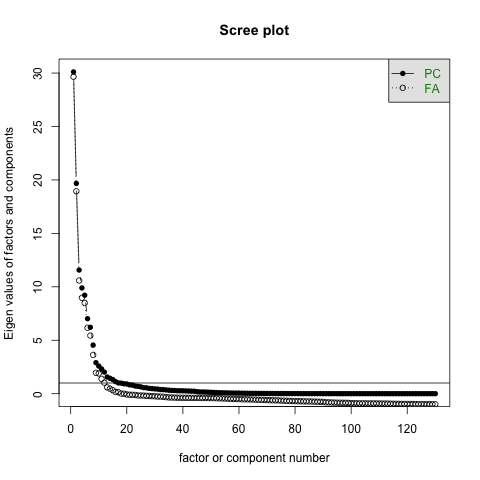

In [187]:
%%R  
library(psych)

scree(df_n_num_nzv_no_meta_trans_noNA)


Parallel analysis suggests that the number of factors =  15  and the number of components =  15 


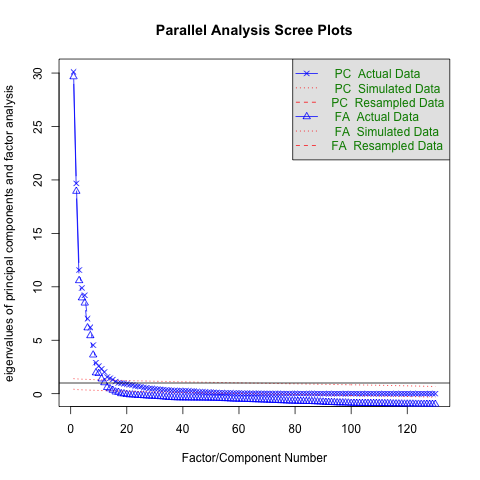

In [188]:
%%R 
res = fa.parallel(df_n_num_nzv_no_meta_trans_noNA)

Analysis with caret package.

In [189]:
%%R
library(caret)

params.pca=preProcess(df_n_num_nzv_no_meta_trans_noNA, method='pca')
df_n_num_nzv_no_meta_trans_noNA_PCA=predict(params.pca, df_n_num_nzv_no_meta_trans_noNA)

print(params.pca)

print(dim(df_n_num_nzv_no_meta_trans_noNA_PCA))

Created from 3549 samples and 130 variables

Pre-processing:
  - centered (130)
  - ignored (0)
  - principal component signal extraction (130)
  - scaled (130)

PCA needed 30 components to capture 95 percent of the variance
[1] 3549   30


In [190]:
%%R
print(df_n_num_nzv_no_meta_trans_noNA_PCA[1:3, 1:4])


         PC1       PC2       PC3       PC4
0 -10.107046  1.219458  1.474683 -1.544114
1   7.420981 -3.137668 -4.394260 -4.473789
2   7.768469 -2.755372  3.865114  1.711574


In [198]:
%%R

print(summary(params.pca))


           Length Class  Mode    
dim           2   -none- numeric 
bc            0   -none- NULL    
yj            0   -none- NULL    
et            0   -none- NULL    
mean        130   -none- numeric 
std         130   -none- numeric 
ranges        0   -none- NULL    
rotation   3900   -none- numeric 
method        4   -none- list    
thresh        1   -none- numeric 
pcaComp       0   -none- NULL    
numComp       1   -none- numeric 
ica           0   -none- NULL    
wildcards     2   -none- list    
k             1   -none- numeric 
knnSummary    1   -none- function
bagImp        0   -none- NULL    
median        0   -none- NULL    
data          0   -none- NULL    


In [192]:
%R

library(ggbiplot)

ggbiplot(df_n_num_nzv_no_meta_trans_noNA_PCA, obs.scale = 1, var.scale = 1, groups=as.character(Y_binary), ellipse=TRUE, circle=FALSE, var.axes=FALSE, ellipse.prob = 0.68, varname.abbrev=TRUE, varname.size = 0, alpha=0.5)+scale_color_manual(values=c('#7F7F7F','#179B33'))


SyntaxError: invalid syntax (<ipython-input-192-7af104b3a67e>, line 5)

### Initial (quick-check) model

The model uses all variables. It is built to see whether the discriminant features are even included in the dataset. 

# V. Feature selection


From experimental point of view, this may be the most actionable information.    
<a name="V" /a>   
<a href=#Top>Top</a>

# VI. Classification model for phenotype scoring    
<a name="VI" /a>


Allows for unbiased experiment quantification based on the CP output.   
<a href=#Top>Top</a>